# Two-step task logistic regression analysis - Replication sample

## Analysis overview

#### Discovery sample

1. Model fitting: [`Model fitting - Discovery.ipynb`](<../../notebooks/discovery/Model fitting - Discovery.ipynb>)
2. Confidence analysis: [`Confidence analysis - Discovery.ipynb`](<../../notebooks/discovery/Confidence analysis - Discovery.ipynb>)
3. Transdiagnostic factor estimation: [`Transdiagnostic factors - Discovery.ipynb`](<../../notebooks/discovery/Transdiagnostic factors - Discovery.ipynb>)
4. Symptom-behaviour analyses: [`Symptom analyses - Discovery.ipynb`](<../../notebooks/discovery/Symptom analyses - Discovery.ipynb>)

#### Replication sample

1. Model fitting: [`Model fitting - Replication.ipynb`](<../../notebooks/replication/Model fitting - Replication.ipynb>)
2. Confidence analysis: [`Confidence analysis - Replication.ipynb`](<../../notebooks/replication/Confidence analysis - Replication.ipynb>)
3. **⭐ Two-step task analysis: [`Two-step modelling - Replication.ipynb`](<../../notebooks/replication/Two-step modelling - Replication.ipynb>)** ⭐
4. Transdiagnostic factor estimation: [`Transdiagnostic factors - Replication.ipynb`](<../../notebooks/replication/Transdiagnostic factors - Replication.ipynb>)
5. Symptom-behaviour analyses: [`Symptom analyses - Replication.ipynb`](<../../notebooks/replication/Symptom analyses - Replication.ipynb>)

#### Test-retest sample

1. Model-fitting: [`Model fitting - Retest.ipynb`](<../../notebooks/retest/Model fitting - Retest.ipynb>)
2. Two-step modelling: [`Two-step modelling - Retest.ipynb`](<../../notebooks/retest/Two-step modelling - Retest.ipynb>)
3. Test-retest reliability analyses: [`Test-retest - Retest.ipynb`](<../../notebooks/retest/Test-retest - Retest.ipynb>)

#### Follow-up sample

1. Model fitting: [`Model fitting - Follow up.ipynb`](<../../notebooks/follow-up/Model fitting - Follow up.ipynb>)
2. Transdiagnostic factor estimation: [`Transdiagnostic factors - Follow up.ipynb`](<../../notebooks/follow-up/Transdiagnostic factors - Follow up.ipynb>)
3. Test-retest reliability analyses: [`Test-retest - Follow up.ipynb`](<../../notebooks/follow-up/Test-retest - Follow up.ipynb>)
4. Longitudinal analyses: [`Longitudinal analyses - Follow up.ipynb`](<../../notebooks/follow-up/Longitudinal analyses - Follow up.ipynb>)

#### Follow-up sample (1 year)

1. Model fitting: [`Model fitting - Follow up 1yr.ipynb`](<../../notebooks/follow-up-1yr/Model fitting - Follow up 1yr.ipynb>)
2. Transdiagnostic factor estimation: [`Transdiagnostic factors - Follow up 1yr.ipynb`](<../../notebooks/follow-up-1yr/Transdiagnostic factors - Follow up 1yr.ipynb>)
3. Test-retest reliability analyses: [`Test-retest - Follow up 1yr.ipynb`](<../../notebooks/follow-up-1yr/Test-retest - Follow up 1yr.ipynb>)
4. Longitudinal analyses: [`Longitudinal analyses -  Follow up 1yr.ipynb`](<../../notebooks/follow-up-1yr/Longitudinal analyses - Follow up 1yr.ipynb>)

## Notebook overview


This notebook runs a logistic regression model on the two-step task data. This enables us to quantify the extent to which each participant's behaviour is guided by model-based versus model-free strategies.


## Imports


In [1]:
# Make sure we use the CPU
import os

os.environ["JAX_PLATFORMS"] = "cpu"

import numpyro

numpyro.set_host_device_count(
    4
)  # Set this to the number of cores you want to use
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from stats_utils.bayesian.utils import arviz_to_markdown_table
from transition_uncertainty.style import set_style
from transition_uncertainty.utils import (
    check_directories,
    save_markdown_tables,
)

set_style("style.mplstyle")

# Raise an error if we're not in the root directory by checking if the data folder exists
check_directories()

# Make sure we use the CPU
import jax

assert (
    str(list(jax.numpy.ones(3).devices())[0]) == "TFRT_CPU_0"
), "CPU not being used by Jax - this is wrong"

/scratch/users/user/miniconda3/envs/tu_test_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/users/user/.local/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Font Heebo already available in Matplotlib.
Matplotlib style set to: style.mplstyle with font Heebo


## Load data


In [2]:
task_df = pd.read_csv("data/task/replication/cannonball-twostep_task_data.csv")

# Print number of subjects
print(f"Number of subjects: {len(task_df.subjectID.unique())}")

Number of subjects: 1400


## Reformat the data

This code performs several transformations on the `task_df` DataFrame, which contains data from a task involving trials where subjects respond to stimuli:

1. **Sorting the DataFrame**: The DataFrame is sorted by 'subjectID' and 'trial' to ensure all trials for a given subject are grouped together and in the correct sequence.

2. **Creating the 'stay' column**: A new column 'stay' is created to indicate whether the subject's response on a given trial was the same as their response on the previous trial. This is achieved by shifting the 'response' column up by one row and comparing it to the original 'response' column. The result is a series of 1s (for True) and 0s (for False).

3. **Dropping the last trial for each subject**: The last trial for each subject is dropped, as the 'stay' column for these trials is not meaningful (there is no next trial to compare to).

4. **Creating the 'rewarded' column**: A new column 'rewarded' is created as the opposite of the 'exploded' column. A reward is coded as 1 and a penalty (exploded) is coded as -1.

5. **Creating the 'common' column**: A new column 'common' is created to indicate whether the subject's response was 'common' or 'rare', based on the color of the ball in the trial. If the ball was pink and the response was 1, or if the ball was purple and the response was 2, this is considered 'common' and coded as 1. Otherwise, it's considered 'rare' and coded as -1.


In [3]:
# Create new column called "stay", which is 1 if the response is the same as
# the previous trial, and 0 otherwise 
# First, sort the DataFrame by subjectID
# and trial to ensure the order is correct
task_df = task_df.sort_values(by=["subjectID", "trial"])

# Create the 'stay' column by comparing the current response with the next
# response
task_df["stay"] = (
    task_df.groupby("subjectID")["response"].shift(-1) == task_df["response"]
)

# Drop the last trial for each subject
task_df = (
    task_df.groupby("subjectID")
    .apply(lambda x: x.iloc[:-1])
    .reset_index(drop=True)
)

# Optional: Convert True/False in 'stay' column to 1/0
task_df["stay"] = task_df["stay"].astype(int)


# Create a reward column - the opposite of "exploded", coded as -1 if exploded,
# and 1 if not
task_df["rewarded"] = (
    task_df["exploded"].replace({False: 1, True: -1}).astype(int)
)

# Create a common/rare column: If ballColour is pink and response is 1, or
# ballColour is purple and response is 2, then common = 1
# If ballColour is pink and response is 2, or ballColour is purple and response
# is 1, then common = -1
task_df["common"] = (
    (task_df["ballColour"] == "pink") & (task_df["response"] == 1)
    | (task_df["ballColour"] == "purple") & (task_df["response"] == 2)
).astype(int)
task_df["common"] = task_df["common"].replace({0: -1})

## Plot behaviour

This code generates a categorical bar plot using Seaborn's `catplot` function. The plot is based on data from `task_df` and plots the probability of staying with the same option according to the outcome on the previous trial (rewarded or not), and whether it was a common or rare transtiion.

We should see a clear interaction here, where people are more likely to stay with the same option if it was rewarded and common, or if it was unrewarded and uncommon, versus unrewarded and common or rewarded and uncommon. This is a hallmark of model-based behaviour in the task.

1. **Creating a new DataFrame with cleaner column names**: A copy of the `task_df` DataFrame is made and the column names are renamed for better readability in the plot. The 'rewarded' column is renamed to 'Rewarded', the 'common' column is renamed to 'Transition', and the 'stay' column is renamed to 'P(Stay)'.

2. **Replacing numerical values with descriptive labels**: The numerical values in the 'Rewarded' and 'Transition' columns are replaced with more descriptive labels. In the 'Rewarded' column, 1 is replaced with 'Unrewarded' and -1 is replaced with 'Rewarded'. In the 'Transition' column, 1 is replaced with 'Common' and -1 is replaced with 'Rare'.

3. **Creating a bar plot**: A bar plot is created using seaborn's `catplot` function. The x-axis represents whether the trial was rewarded or not, the y-axis represents the proportion of 'stay' choices, and different colors represent whether the transition was common or rare. The bars have black outlines and error bars with caps.

4. **Limiting the y-axis range**: The range of the y-axis is limited to 0.5-0.8 for better visualization of the differences between the bars.


(0.5, 0.8)

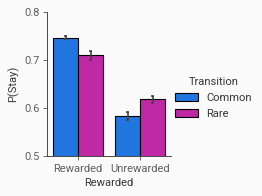

In [4]:
# Create a new dataframe with cleaner column names for plotting
task_df_plot = task_df.copy().rename(
    columns={"rewarded": "Rewarded", "common": "Transition", "stay": "P(Stay)"}
)
task_df_plot["Rewarded"] = task_df_plot["Rewarded"].replace(
    {1: "Rewarded", -1: "Unrewarded"}
)
task_df_plot["Transition"] = task_df_plot["Transition"].replace(
    {1: "Common", -1: "Rare"}
)

# Plot the proportion of stay choices for rewarded and unrewarded trials
sns.catplot(
    x="Rewarded",
    y="P(Stay)",
    hue="Transition",
    data=task_df_plot,
    kind="bar",
    order=["Rewarded", "Unrewarded"],
    hue_order=["Common", "Rare"],
    edgecolor="black",
    capsize=0.1,
    height=2.5,
)

# Limit y axis to 0.5-1
plt.ylim(0.5, 0.8)

## Run a hierarchical logistic regression model

The code involves data preprocessing and fitting a Bayesian hierarchical logistic regression model using the `bmb.Model` function.

1. **Data Preprocessing**:

    - `task_df['subjectID'] = task_df['subjectID'].astype('category')`: Converts the 'subjectID' column in `task_df` to a categorical variable. This is done to ensure that the 'subjectID' column is treated as a grouping variable in the model.

2. **Building the Model**:

    - `model = bmb.Model(...)`: Creates a Bayesian hierarchical logistic regression model. The model formula is specified within the function.
        - `'stay ~ 1 + rewarded + (rewarded|subjectID) + common + (common|subjectID) + rewarded:common + (rewarded:common|subjectID)'`: This formula sets 'stay' as the dependent variable. It includes fixed effects (`rewarded`, `common`, and their interaction `rewarded:common`) and random effects ((`rewarded|subjectID`), (`common|subjectID`), and (`rewarded:common|subjectID`)) which allow the effects of `rewarded` and `common` to vary across different `subjectID`s.
        - `data=task_df`: Uses `task_df` as the dataset for the model.
        - `family='bernoulli'`: Indicates that the dependent variable is binary (Bernoulli distribution), which is typical for logistic regression.

3. **Fitting the Model**:
    - `results = model.fit()`: Fits the model to the data. The fitted model is stored in `results`. This process involves estimating the parameters of the model based on the provided data.


In [5]:
# Ensure 'subjectID' is treated as a categorical variable
task_df["subjectID"] = task_df["subjectID"].astype("category")

# Building the Bayesian hierarchical logistic regression model
model = bmb.Model(
    "stay ~ 1 + (1|subjectID) + rewarded + (rewarded|subjectID) + common + "
    "(common|subjectID) + rewarded:common + (rewarded:common|subjectID)",
    data=task_df,
    family="bernoulli",
)

# Fitting the model
results = model.fit(
    draws=8000,
    tune=2000,
    chains=4,
    random_seed=42,
    target_accept=0.85,
    inference_method="nuts_numpyro",
)

# Store the markdown table in a variable
results_table = arviz_to_markdown_table(
    results,
    var_names=["common", "rewarded", "rewarded:common"],
    predictor_rename_dict={
        "common": "Transition",
        "rewarded": "Rewarded",
        "rewarded:common": "Rewarded x Transition",
    },
)

Modeling the probability that stay==1
Compiling.. :   0%|                                                                                                                                      | 0/10000 [00:00<?, ?it/s]







Running chain 0:   5%|█████▉                                                                                                                 | 500/10000 [06:06<1:54:36,  1.38it/s]


Running chain 0:  10%|████████████                                                                                                            | 1000/10000 [07:30<59:33,  2.52it/s]


Running chain 0:  15%|██████████████████                                                                                                      | 1500/10000 [08:50<40:55,  3.46it/s]


Running chain 0:  20%|████████████████████████                                                                                                | 2000/10000 [10:10<31:44,  4.20it/s]


Running chain 0:  25%|█████████████████████████

### Print a summary of the group-level effects

A positive `rewarded:common` effect indicates that people are in general using a model-based strategy.


In [6]:
az.summary(
    results,
    hdi_prob=0.95,
    var_names=["common", "rewarded", "rewarded:common"],
    round_to=3,
)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
common,0.020,0.011,-0.000,0.041,0.0,0.0,38267.561,24645.688,1.0
rewarded,0.416,0.021,0.375,0.456,0.0,0.0,7439.279,14323.636,1.0
rewarded:common,0.118,0.013,0.093,0.143,0.0,0.0,23339.920,24411.891,1.0


### Get the subject-level interaction effects

The subject-level `rewarded:common` effects indicate the extent to which each subject's behaviour is guided by model-based versus model-free strategies. Note that this is relative to the group-level effect, and so the mean is 0.


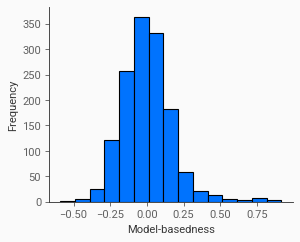

In [7]:
subject_effects = (
    results.posterior["rewarded:common|subjectID"]
    .stack(draws=["draw", "chain"])
    .mean(dim="draws")
)

# Create figure
plt.figure(figsize=(3.5, 3))

# Plot as a histogram with black outline
plt.hist(subject_effects, edgecolor="black", bins=15)

# Update labels
plt.xlabel("Model-basedness")
plt.ylabel("Frequency")

# Remove top and right spines
sns.despine()

### Export to CSV

Finally we save the results for further analyses.


In [8]:
# Create a dataframe
subject_effects_df = pd.DataFrame(subject_effects, columns=["parameter"])

# Add a column for subjectID
subject_effects_df["subjectID"] = task_df["subjectID"].unique()

# Create the output directory if it doesnt exist
if not os.path.exists("results/replication/two-step_model-fit"):
    os.makedirs("results/replication/two-step_model-fit")

# Save to CSV
subject_effects_df.to_csv(
    "results/replication/two-step_model-fit/twostep_subject_effects.csv",
    index=False,
)

### Save results tables as Markdown

In [9]:
# Create the caption with proper formatting
caption = (
    "Coefficients for Bayesian logistic regression model predicting "
    "stay choices in the two-step task. "
    "from model-derived uncertainty metrics in the **replication** sample. "
    "$\\mu$ = posterior mean, $\\sigma$ = posterior standard deviation, "
    "$HDI_{2.5}$ = 2.5% highest density interval, "
    "$HDI_{97.5}$ = 97.5% highest density interval."
)

# Save the markdown tables with the caption
save_markdown_tables(
    [results_table],
    [caption],
    "paper/supplementary_tables.md",
    prepend_string="# Supplementary tables",
)

Creating or overwriting file: paper/supplementary_tables.md
Conversion to PDF completed successfully.
Conversion to docx completed successfully.
